# Regression using Decision Trees

In this notebook, we will use decision trees to solve regression problems. 

The dataset used here originates from a project to build a surrogate model for predicting the band gap of a material from its composition. This surrogate model was used to replace expensive qunatum mecahnical calculations in virtual high-throughput screening of materials for application as photocatalysts. The paper was published in [Chemistry of Materials](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.9b01519). 

![image.png](attachment:image.png)

Through this pracitcal, we will learn not only the usage of regression trees but, more importantly, how to tune hyperparameters for best performance.

## Set up the Python environment

Run the cell below to import the various packages that we will use.

In [ ]:
# sklearn
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.datasets

# helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

---

# The Dataset

We initially download the data from `zenodo`. The data repo is [here](https://zenodo.org/record/4450207).

Our data are stored in the pickle file `./training_data.pickle`. We load this file into a `pandas.DataFrame` object, an efficient interface to manage column-wise, heterogeneous tabular data. 

In [ ]:
!wget https://zenodo.org/record/4450207/files/training_data.pickle
oxides = pd.read_pickle('./training_data.pickle')

--2022-02-17 14:57:46--  https://zenodo.org/record/4450207/files/training_data.pickle
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 900335 (879K) [application/octet-stream]
Saving to: ‘training_data.pickle.1’

training_data.pickl 100%[===================>] 879.23K   269KB/s    in 3.3s    

2022-02-17 14:57:52 (269 KB/s) - ‘training_data.pickle.1’ saved [900335/900335]



We can check all the columns presented in the dataframe:

In [ ]:
list(oxides.columns)

['gllbsc_gap',
 '0-norm',
 '2-norm',
 '3-norm',
 '5-norm',
 '7-norm',
 '10-norm',
 'MagpieData minimum Number',
 'MagpieData maximum Number',
 'MagpieData range Number',
 'MagpieData mean Number',
 'MagpieData avg_dev Number',
 'MagpieData mode Number',
 'MagpieData minimum MendeleevNumber',
 'MagpieData maximum MendeleevNumber',
 'MagpieData range MendeleevNumber',
 'MagpieData mean MendeleevNumber',
 'MagpieData avg_dev MendeleevNumber',
 'MagpieData mode MendeleevNumber',
 'MagpieData minimum AtomicWeight',
 'MagpieData maximum AtomicWeight',
 'MagpieData range AtomicWeight',
 'MagpieData mean AtomicWeight',
 'MagpieData avg_dev AtomicWeight',
 'MagpieData mode AtomicWeight',
 'MagpieData minimum MeltingT',
 'MagpieData maximum MeltingT',
 'MagpieData range MeltingT',
 'MagpieData mean MeltingT',
 'MagpieData avg_dev MeltingT',
 'MagpieData mode MeltingT',
 'MagpieData minimum Column',
 'MagpieData maximum Column',
 'MagpieData range Column',
 'MagpieData mean Column',
 'MagpieData 

### Description of the dataset

In this practical we are attempting to learn a model that can predict the band gap (energy separation between occupied and un-occupied orbitals) of a material. So we need to set this value as the property to be predicted $y$ This data is stored in the dataframe column called `gllbsc_gap` and we set this to be y by running the cell below:

In [ ]:
# read a single column
y = oxides['gllbsc_gap'].values

We can then use the other properties in the dataset, or a combination of them as *features* ($X$) for our model. For example we could set $X$ to be defined by two features by running the cell below:

In [ ]:
# read multiple columns and combine them to a matrix
X = oxides[['MagpieData minimum MeltingT', 'HOMO_energy']].values
print(X.shape)

(749, 2)


In [ ]:
X[0]

array([54.8     , -0.160771])

## Regression with the dataset

In regression, we attempt to fit a model, $y = f(x)$, where $x$ and $y$ are multi-dimensional data of rank $M$ and $N$, respectively, and $f: \mathbb{R}^M\rightarrow\mathbb{R}^N$ our regression model. In this notebook, $y$ will always be `gllbsc_gap` (so $N=1$), which represents the band gap, and $x$ a combination of the descriptors (all the other columns), each giving the measurement of a certain physical property. 

# Linear regression: a starter

Linear regression is the simplest regression algorithm in machine learning. Many people do not even regard it as a machine learning algorithm because it is explicitly programmed. Still, it serves as a good start to learn some basic concepts.


## Univariate regression

In univariate linear regression we have the equation:
$y = mx + c$
and we are attempting to find the best values for $m$ and $c$

In a univariate regression, the input rank $M=1$. For instance, let us try `MagpieData avg_dev Electronegativity` as $x$:

In [ ]:
# read X
X = oxides['gap_AO'].values
# we need to append a dummy dimension to X for univariate regression
# to keep the input dimensions consistent with multivariate regression
X = X.reshape(-1, 1)
# read y
y = oxides['gllbsc_gap'].values

Now we can use linear regression to fit the data and make predictions:

In [ ]:
# fit linear regression model
model = LinearRegression().fit(X, y)
# make predictions
y_pred = model.predict(X)

When we have fitted the model we now want to use some *metrics* to *evaluate* the model performance. Remember the mean squared error and mean absolute error from your lectures. We will now calculate them for the model:

In [ ]:
# compute some fitting error
print('MSE = %f eV' % metrics.mean_squared_error(y, y_pred))
print('MAE = %f eV' % metrics.mean_absolute_error(y, y_pred))

MSE = 5.310607 eV
MAE = 1.865350 eV


We can also plot the predicted versus the real values to get a visual feel for how well the fitting worked.

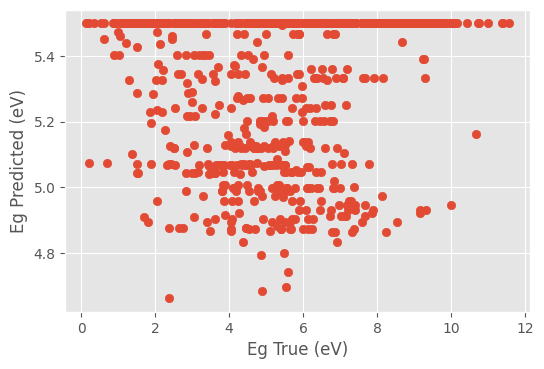

In [ ]:
plt.figure(dpi=100)
plt.scatter(y, y_pred)
plt.xlabel('Eg True (eV)')
plt.ylabel('Eg Predicted (eV)')
plt.show()

## Exercise 

By changeing the feature in the $X$ values above try a number of different features (four or five is enough). How does it affect the quality of fitting? Report the feature and the MAE and MSE scores in the table below. *Note* to edit the contets of this cell, simply double click on the cell.

| Feature | MAE (eV) | MSE (eV) |
|---------|----------|----------|
|   MagpieData avg_dev Electronegativity      |     1.833979      |   5.157564        |
|    MagpieData mean GSbandgap     |   1.837296        |   5.098993        |
|    avg ionic char     |    1.836546       |     5.167330      |
|   gap_AO      |     1.865350      |    5.310607       |

## Multivariate regression

In a multivariate regression, the input rank $M>1$. Therefore, we will choose a few descriptor to form $x$. Here we choose three descriptors ($M=3$):

In [ ]:
# read X
X = oxides[['HOMO_energy', 
            'MagpieData range Electronegativity', 
            'LUMO_energy']].values

And the rest is the same as univariate regression:

MSE = 3.527691
MAE = 1.475324


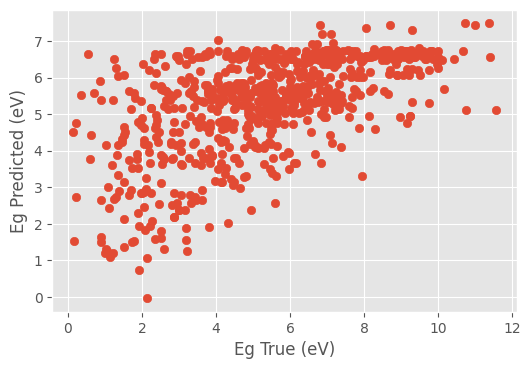

In [ ]:
# fit linear regression model
model = LinearRegression().fit(X, y)

# make predictions
y_pred = model.predict(X)

# compute some fitting error
print('MSE = %f' % metrics.mean_squared_error(y, y_pred))
print('MAE = %f' % metrics.mean_absolute_error(y, y_pred))

# plot the original and predicted data against each other
plt.figure(dpi=100)
plt.scatter(y, y_pred)
plt.xlabel('Eg True (eV)')
plt.ylabel('Eg Predicted (eV)')
plt.show()

## Exercise 

By changeing the features in the $X$ values above try a number of different feature combinations (again four or five examples is enough, you can try with any number of features in each example that you like). How does it affect the quality of fitting? Report the feature and the MAE and MSE scores in the table below. *Note* to edit the contets of this cell, simply double click on the cell.

| Feature | MAE (eV) | MSE (eV) |
|---------|----------|----------|
|   'HOMO_energy', 
            'MagpieData avg_dev Electronegativity', 
            'LUMO_energy      |     1.518440     | 3.751034         |
|    'HOMO_energy', 
            'MagpieData avg_dev GSvolume_pa', 
            'LUMO_energy'     |    1.560588      |     3.881334     |
|     'HOMO_energy', 
            'MagpieData range Electronegativity', 
            'LUMO_energy'    |     1.475324     |     3.527691     |

---

# Gradient Boosting Regression

Gradient boosting is a method for building an ensemble of weak learners to constitute a single strong learner. We build a series of decision trees, each subsequent tree taking in information about the residuals (errors) from the previous trees. In principle, the fitting should improve each time a new tree is added. 

## 1. Create the regressor

In `sklearn`, a gradient boosting regressor is created by

```python
GradientBoostingRegressor(loss=<str>, max_depth=<int>, learning_rate=<float>,
                          min_samples_split=<int>, min_samples_leaf=<int>, 
                          max_features=<int>, subsample=<float>, n_estimators=<int>)
```


The hyperparameters we need to set include:

* `loss`: a loss function to be minimised. We will use 'lad', which is basically MAE.
* `max_depth`: the maximum depth limits the number of nodes in the trees; its best value depends on the interaction of the input variables; we will start with 10 and can tune it later.
* `learning_rate`: learning rate shrinks the contribution of each tree; there is a trade-off between learning rate and boosting steps; we will start with 0.015 and can tune it later.
* `min_samples_split`: the minimum number of samples required to split an internal node; we will start with 50 and can tune it later.
* `min_samples_leaf`: the minimum number of samples required to be at a leaf node; we set this as 1.
* `max_features`: the number of features to consider when looking for the best split; we will use the number of features in the data.
* `subsample`: the fraction of samples to be used for fitting the individual trees; if smaller than 1.0, this results in Stochastic Gradient Boosting. we will start with 0.9 and can tune it later.
* `n_estimators`: the number of boosting steps or decision trees; we will start with 300 and can tune it later.

**NOTE**: Simply adding more trees can lead to overfitting. Gradient boosting is quite robust against overfitting, but we will have to look out for this.

In [ ]:
# create the regressor
gbr = GradientBoostingRegressor(loss='lad', max_depth=10, learning_rate=0.015,
                                min_samples_split=50, min_samples_leaf=1, 
                                max_features=len(oxides.columns)-1, subsample=0.9, 
                                n_estimators=300)

## 2. Fit the regressor

First of all we write some code that sets $X$ to be all of the features **except** `gllbsc_gap`

In [ ]:
# combine all the columns into X
cols = [a for a in list(oxides.columns) if a not in ['gllbsc_gap']]
X = oxides[cols].values
print('Shape of X: %s' % str(X.shape))

Shape of X: (749, 148)


We then fit the model that we have defined to find $f(X) = y$

In [ ]:
# fit the model
gbr.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,


GradientBoostingRegressor(learning_rate=0.015, loss='lad', max_depth=10,
                          max_features=148, min_samples_split=50,
                          n_estimators=300, subsample=0.9)

After fitting the model, we can make predictions and plot them against the original data. The fit has shown a significant improvement over linear regression. 

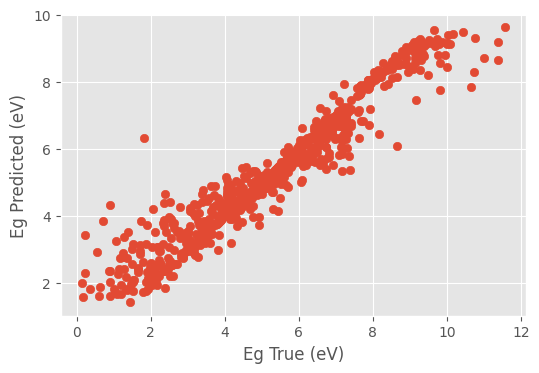

In [ ]:
# make predictions
y_pred = gbr.predict(X)

# plot the original and predicted data against each other
plt.figure(dpi=100)
plt.scatter(y, y_pred)
plt.xlabel('Eg True (eV)')
plt.ylabel('Eg Predicted (eV)')
plt.show()

In [ ]:
plt.xlabel('Eg True (eV)')
plt.ylabel('Eg Predicted (eV)')

## Exercise

Calcuate the mean absolute error and the mean squared error for the plot above.

In [ ]:
# compute some fitting error
print('MSE = %f eV' % metrics.mean_squared_error(y, y_pred))
print('MAE = %f eV' % metrics.mean_absolute_error(y, y_pred))

MSE = 0.483054 eV
MAE = 0.419933 eV


## 3. Cross validation

Cross-validation (CV) allows us to evaluate the out-of-sample goodness-of-fit of the regressor without sparing a validation set. In the basic approach, called the k-fold CV, the training set is split into $k$ subsets, each serving as the validation set to evaluate the model trained with the other $k-1$ subsets. This approach can be computationally expensive but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage for problems with limited data.

In the following cell, we compute the scores using 5 folds (so 20% of data for each validation) and the negative MAE as the metric:

In [ ]:
# compute cross validation score
scores = cross_val_score(gbr, X, y, cv=5, scoring='neg_mean_absolute_error')


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be rem

Cross validation score: 0.9262503091266117


In [ ]:
print('Cross validation score: {} eV'.format(-1 * np.mean(scores)))

Cross validation score: 0.9262503091266117 eV


## 4. Boosting rate and overfitting

Let us split the dataset 80:20 into training and test sets.  We can use the `train_test_split` function from `scikit-learn` to do this.

Re-fit the model using the training set only. 

We can then use some built-in methods of `GradientBoostingRegressor` to get training and test scores at each iteration of boosting. This way, we can check if we have insufficient boosting layers or perhaps we have too many and thus suffer overfitting.


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,


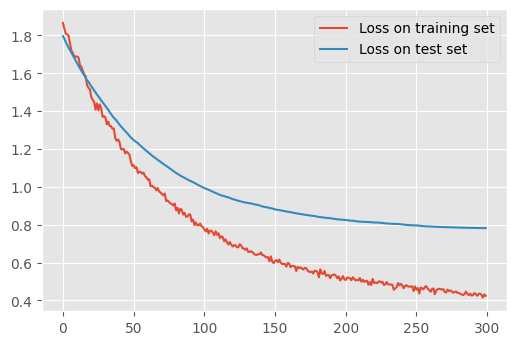

In [ ]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# fit with training set
gbr.fit(X_train, y_train)

# compute test score at each boosting step
test_score = np.zeros((300,), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)

# plot the scores
plt.figure(dpi=100)
plt.plot(gbr.train_score_, label='Loss on training set')
plt.plot(test_score, label='Loss on test set')
plt.legend()
plt.show()

Notice that the loss of both training and test are still decreasing at 300 steps. We can try to increase the boosting steps to 500 and see if we can still get improvements. If the test score stops increasing, we are probably in a good place to stop extending the model. 

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,


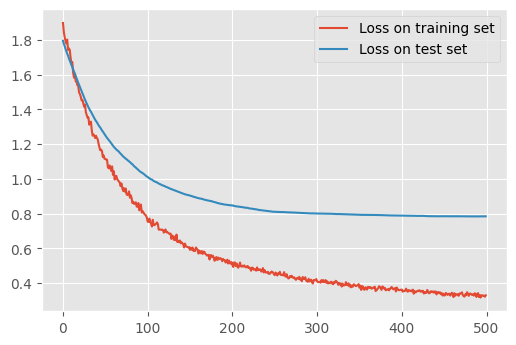

In [ ]:
# create the regressor with more boosting steps
gbr500 = GradientBoostingRegressor(loss='lad', max_depth=10, learning_rate=0.015,
                                   min_samples_split=50, min_samples_leaf=1, 
                                   max_features=len(oxides.columns)-1, subsample=0.9, 
                                   n_estimators=500)

# fit with training set
gbr500.fit(X_train, y_train)

# compute test score at each boosting step
test_score = np.zeros((500,), dtype=np.float64)
for i, y_pred in enumerate(gbr500.staged_predict(X_test)):
    test_score[i] = gbr500.loss_(y_test, y_pred)

# plot the scores
plt.figure(dpi=100)
plt.plot(gbr500.train_score_, label='Loss on training set')
plt.plot(test_score, label='Loss on test set')
plt.legend()
plt.show()

## Exercise

Repeat the procedure above, but this time try to run up to 1000 boosting steps.

**Hint**
<details>
You need to copy the code above, but reset:
    
    * n_estimators
    
    * the size of test_score = np.zeros((500,), dtype=np.float64)
</details>

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,


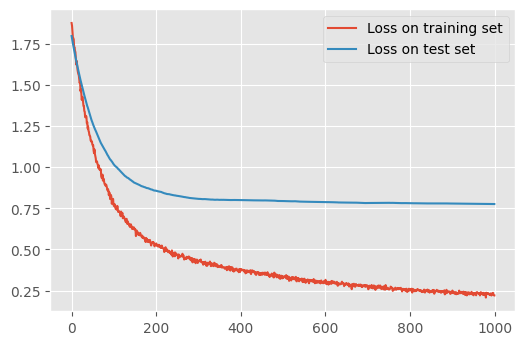

In [ ]:
# create the regressor with more boosting steps
gbr1000 = GradientBoostingRegressor(loss='lad', max_depth=10, learning_rate=0.015,
                                   min_samples_split=50, min_samples_leaf=1, 
                                   max_features=len(oxides.columns)-1, subsample=0.9, 
                                   n_estimators=1000)

# fit with training set
gbr1000.fit(X_train, y_train)

# compute test score at each boosting step
test_score = np.zeros((1000,), dtype=np.float64)
for i, y_pred in enumerate(gbr1000.staged_predict(X_test)):
    test_score[i] = gbr1000.loss_(y_test, y_pred)

# plot the scores
plt.figure(dpi=100)
plt.plot(gbr1000.train_score_, label='Loss on training set')
plt.plot(test_score, label='Loss on test set')
plt.legend()
plt.show()

Again, do a 5-fold cross validation at this point. How does the score compare to the earlier one?

**Hint**
<details>
    
```
 # compute cross validation score
scores = cross_val_score(gbr500, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Cross validation score: {}'.format(-1 * np.mean(scores)))
```
</details>

In [ ]:
# compute cross validation score
scores = cross_val_score(gbr1000, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Cross validation score: {} eV'.format(-1 * np.mean(scores)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be rem

Cross validation score: 0.8949343521250024 eV


##  5. Systematic hyperparameter tuning

Hand tuning a large number of hyperparameters is laborious. Luckily, `sklearn` provides a function [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to automate searches in the hyperparameter space. Even though, performing a grid-search of all of the hyperparameters at once would again lead to a combinatorial explosion. A general strategy for tuning hyperparameters in gradient boosted trees has been suggested [here](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/). 

1. Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems.
2. Determine the optimum number of trees for this learning rate. This should range around 40 to 90. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.
3. Tune tree-specific parameters for decided learning rate and number of trees. 
4. Lower the learning rate and increase the estimators proportionally to get more robust models.

We will follow the above process to tune our regressor.


### Step 1 & 2: Optimise `n_estimators` with `learning_rate=0.1`

In the cell below we search between 40 and 90 estimators in steps of 10.

We then define our model `gbr_n_est`

We then define the grid search `gsearch`

Finally we tell the grid search to run with `fit`

In [ ]:
# candidates
param_test_n_est = {'n_estimators': range(40, 90, 10)}

# create the regressor
gbr_n_est = GradientBoostingRegressor(loss='lad', learning_rate=0.1, 
                                      max_features=len(cols), max_depth=10,
                                      min_samples_split=50, subsample=0.9,
                                      random_state=0)

# define hyperparameter search
gsearch = GridSearchCV(estimator= gbr_n_est, param_grid = param_test_n_est, 
                       scoring='neg_median_absolute_error', cv=5)

# perform search
gsearch.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be rem

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(loss='lad', max_depth=10,
                                                 max_features=148,
                                                 min_samples_split=50,
                                                 random_state=0,
                                                 subsample=0.9),
             param_grid={'n_estimators': range(40, 90, 10)},
             scoring='neg_median_absolute_error')

### Find the best values

We can get the values of the best model from our defined range, in this case we have only `n_estimators` to examine.

In [ ]:
# print best n_estimators
gsearch.best_params_

{'n_estimators': 70}

### Step 3: Optimise tree parameters with best `n_estimators`

Here we consider `max_depth` and `min_samples_split`:

For depth we search between 5 and 16 in steps of 2.
For min samples split we search between 10 and 100 in steps of 20

* Question - how many models in total does this result in?

**Answer**
<details>
 
6 steps for depts $\times$ 5 steps for split $=$ 30 models
    
</details>

In [ ]:
# candidates
param_test_tree = {'max_depth': range(5, 16, 2), 
                   'min_samples_split': range(10, 100, 20)}

# create the regressor
gbr_tree = GradientBoostingRegressor(loss='lad', learning_rate=0.1, 
                                     max_features=len(cols), subsample=0.9,
                                     n_estimators=70, random_state=0)

# define hyperparameter search
gsearch = GridSearchCV(estimator= gbr_tree, param_grid = param_test_tree, 
                       scoring='neg_median_absolute_error', cv=5)

# perform search
gsearch.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be rem

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(loss='lad', max_features=148,
                                                 n_estimators=70,
                                                 random_state=0,
                                                 subsample=0.9),
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(10, 100, 20)},
             scoring='neg_median_absolute_error')

### Exercise

Find the best values, using similar code to the previous time

**Hint**

<details>

```
gsearch.best_params_
```

</details>

In [ ]:
gsearch.best_params_

{'max_depth': 7, 'min_samples_split': 10}

### Step 4: Lower `learning_rate` and increase `n_estimators`

Here we use a factor of 5, so `learning_rate` is lowered to 0.2 and `n_estimators` increased to 350:

In [ ]:
# create the "optimised" regressor
gbr_opt = GradientBoostingRegressor(loss='lad', learning_rate=0.02, 
                                    max_features=len(cols), max_depth=7,
                                    min_samples_split=10, subsample=0.9,
                                    n_estimators=350, random_state=0)

# fit the model
gbr_opt.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,


GradientBoostingRegressor(learning_rate=0.02, loss='lad', max_depth=7,
                          max_features=148, min_samples_split=10,
                          n_estimators=350, random_state=0, subsample=0.9)

Eventually, we can use our "optimised" model to make predictions and compute CV scores:

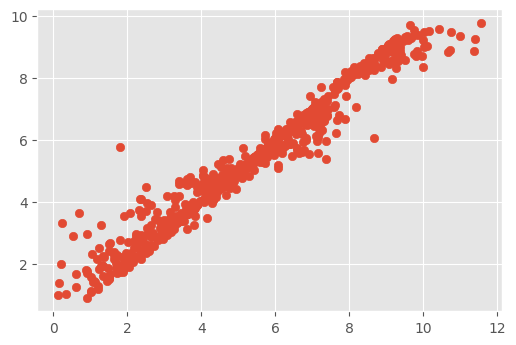

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be rem

Cross validation score: 0.9102752755489126


In [ ]:
# make predictions
y_pred = gbr_opt.predict(X)

# plot the original and predicted data against each other
plt.figure(dpi=100)
plt.scatter(y, y_pred)
plt.show()

# compute cross validation score
scores = cross_val_score(gbr_opt, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Cross validation score: {}'.format(-1 * np.mean(scores)))

In [ ]:
# create the "optimised" regressor
gbr_opt = GradientBoostingRegressor(loss='lad', learning_rate=0.02, 
                                    max_features=len(cols), max_depth=7,
                                    min_samples_split=10, subsample=0.9,
                                    n_estimators=1000, random_state=0)

# fit the model
gbr_opt.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,


GradientBoostingRegressor(learning_rate=0.02, loss='lad', max_depth=7,
                          max_features=148, min_samples_split=10,
                          n_estimators=1000, random_state=0, subsample=0.9)

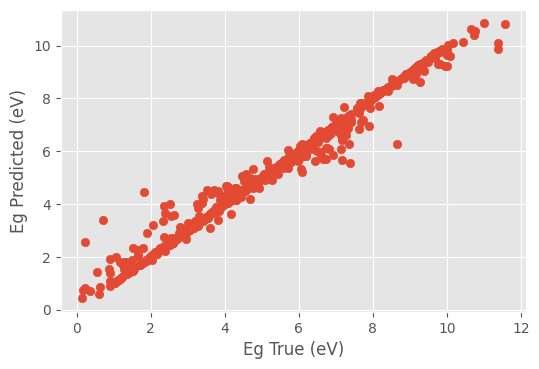

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be rem

Cross validation score: 0.8848889001913122


In [ ]:
# make predictions
y_pred = gbr_opt.predict(X)

# plot the original and predicted data against each other
plt.figure(dpi=100)
plt.scatter(y, y_pred)
plt.xlabel('Eg True (eV)')
plt.ylabel('Eg Predicted (eV)')
plt.show()

# compute cross validation score
scores = cross_val_score(gbr_opt, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Cross validation score: {}'.format(-1 * np.mean(scores)))

**Yes, our efforts pay off**, as shown by the figure and the CV score!

---

## Feature importance

We can look at how much a certain feature contributes to the model by looking at `gbr_opt.feature_importances_`

In the cell below we plot the feature importances on a bar chart, hopefully you see that importance drops off quite quickly and some features have little contribution to the model.

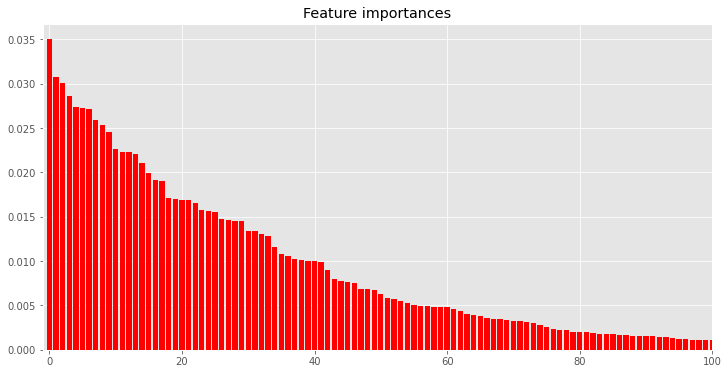

In [ ]:
importances = gbr_opt.feature_importances_

indices = np.argsort(importances)[::-1]

# Plot the impurity-based feature importances of the forest
fig, ax = plt.subplots(1, figsize=(12,6))

ax.set_title("Feature importances")
ax.bar(range(X.shape[1]), importances[indices],
        color="r", align="center")
#plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, 100])
plt.show()

We can also list the features in order of importance and see which features contribute most to the model.

In [ ]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
   print("%d. %s (%f)" % (f + 1, cols[indices[f]], importances[indices[f]]))

Feature ranking:
1. MagpieData avg_dev Number (0.035025)
2. MagpieData avg_dev NValence (0.030774)
3. MagpieData avg_dev AtomicWeight (0.030087)
4. MagpieData mean NValence (0.028626)
5. MagpieData avg_dev MeltingT (0.027389)
6. MagpieData mean MeltingT (0.027277)
7. MagpieData avg_dev CovalentRadius (0.027140)
8. MagpieData avg_dev SpaceGroupNumber (0.025873)
9. MagpieData avg_dev GSvolume_pa (0.025298)
10. MagpieData avg_dev NdValence (0.024573)
11. MagpieData avg_dev MendeleevNumber (0.022644)
12. MagpieData mean GSvolume_pa (0.022340)
13. HOMO_energy (0.022281)
14. MagpieData avg_dev Electronegativity (0.022048)
15. MagpieData mean CovalentRadius (0.021032)
16. MagpieData mean SpaceGroupNumber (0.019976)
17. avg ionic char (0.019199)
18. MagpieData mean AtomicWeight (0.019074)
19. MagpieData mean Electronegativity (0.017117)
20. MagpieData avg_dev Row (0.016976)
21. MagpieData mean GSbandgap (0.016899)
22. gap_AO (0.016886)
23. band center (0.016598)
24. MagpieData mean NpUnfilled 

## Exercises 

It is often desrireable to fit a model using fewer features as this protects against overfitting and also gives models that are easier to interpret. Using the information above build a gradient boosted decision tree, but use **only** the top fifty most important features from the old model. What kind of validation accuracy can you achieve?

**Hint 1**

<details>
    
To build a new X with just the top 50 features you can use code like below.
    
**Note** be sure to call this a new name so that you do not overwrite X
    
```
xtops = [cols[i] for i in indices[:50]]
# combine all the columns into Xs
Xs = oxides[xtops].values  
    
```
    
</details>

**Hint 2**
<details>
    
Remember when setting up your `GradientBoostingRegressor` that the `max_features` should now be set to 50
    
</details>

In [ ]:
xtops = [cols[i] for i in indices[:50]]
# combine all the columns into Xs
Xs = oxides[xtops].values  


In [ ]:
# candidates
param_test_n_est = {'n_estimators': range(40, 90, 10)}

# create the regressor
gbr_n_est = GradientBoostingRegressor(loss='lad', learning_rate=0.1, 
                                      max_features=50, max_depth=10,
                                      min_samples_split=50, subsample=0.9,
                                      random_state=0)

# define hyperparameter search
gsearch = GridSearchCV(estimator=gbr_n_est, param_grid = param_test_n_est, 
                       scoring='neg_median_absolute_error', cv=5)

# perform search
gsearch.fit(Xs, y)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be rem

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(loss='lad', max_depth=10,
                                                 max_features=50,
                                                 min_samples_split=50,
                                                 random_state=0,
                                                 subsample=0.9),
             param_grid={'n_estimators': range(40, 90, 10)},
             scoring='neg_median_absolute_error')

When you have built the model and fitted it, use the cross-validation routine from above to check how well it works.

**Hint**

<details>
 
Make sure that you are feeding the correct model and X and y data to the `cross_val_score` function.
It should get the model that you have just defined and the X data you defined just about too, **not** the X data from the earlier fitting. 
    
</details>

## Exercise

Do the hyperparameter tuning as detailed above and see how good you can make this smaller model.

In [ ]:
gsearch.best_params_

{'n_estimators': 80}

In [ ]:
# candidates
param_test_tree = {'max_depth': range(5, 16, 2), 
                   'min_samples_split': range(10, 100, 20)}

# create the regressor
gbr_tree = GradientBoostingRegressor(loss='lad', learning_rate=0.1, 
                                     max_features=50, subsample=0.9,
                                     n_estimators=80, random_state=0)

# define hyperparameter search
gsearch = GridSearchCV(estimator= gbr_tree, param_grid = param_test_tree, 
                       scoring='neg_median_absolute_error', cv=5)

# perform search
gsearch.fit(Xs, y)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be rem

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(loss='lad', max_features=50,
                                                 n_estimators=80,
                                                 random_state=0,
                                                 subsample=0.9),
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(10, 100, 20)},
             scoring='neg_median_absolute_error')

In [ ]:
gsearch.best_params_

{'max_depth': 15, 'min_samples_split': 70}

In [ ]:
# create the "optimised" regressor
gbr_opt = GradientBoostingRegressor(loss='lad', learning_rate=0.02, 
                                    max_features=50, max_depth=15,
                                    min_samples_split=70, subsample=0.9,
                                    n_estimators=1500, random_state=0)

# fit the model
gbr_opt.fit(Xs, y)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,


GradientBoostingRegressor(learning_rate=0.02, loss='lad', max_depth=15,
                          max_features=50, min_samples_split=70,
                          n_estimators=1500, random_state=0, subsample=0.9)

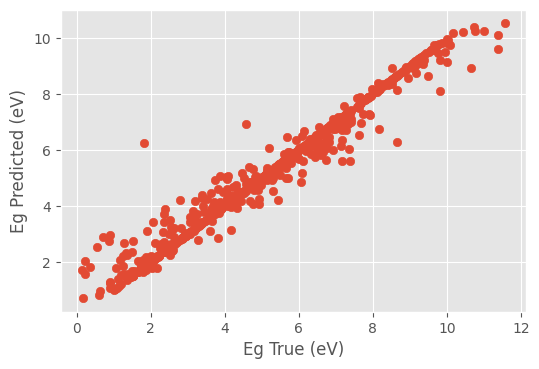

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be rem

Cross validation score: 0.9246003789198631


In [ ]:
# make predictions
y_pred = gbr_opt.predict(Xs)

# plot the original and predicted data against each other
plt.figure(dpi=100)
plt.scatter(y, y_pred)
plt.xlabel('Eg True (eV)')
plt.ylabel('Eg Predicted (eV)')
plt.show()

# compute cross validation score
scores = cross_val_score(gbr_opt, Xs, y, cv=5, scoring='neg_mean_absolute_error')
print('Cross validation score: {}'.format(-1 * np.mean(scores)))

In [ ]:
xm = [cols[i] for i in indices[:3]]

MSE = 2.145250
MAE = 1.127809


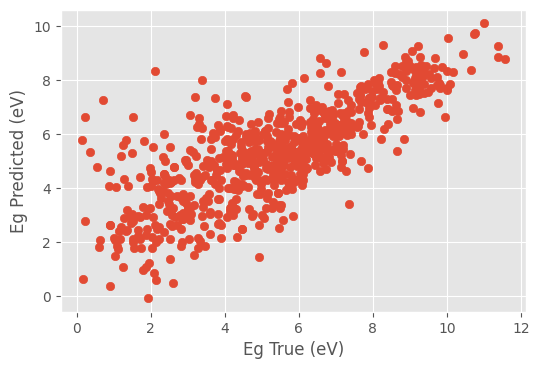

In [ ]:
# read X
Xm = oxides[[cols[i] for i in indices[:20]]].values


# fit linear regression model
model = LinearRegression().fit(Xm, y)

# make predictions
y_pred = model.predict(Xm)

# compute some fitting error
print('MSE = %f' % metrics.mean_squared_error(y, y_pred))
print('MAE = %f' % metrics.mean_absolute_error(y, y_pred))

# plot the original and predicted data against each other
plt.figure(dpi=100)
plt.scatter(y, y_pred)
plt.xlabel('Eg True (eV)')
plt.ylabel('Eg Predicted (eV)')
plt.show()